In [166]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
import operator
import tensorflow as tf
import pandas as pd
import sys


In [169]:
def plot_image(img, figsize=(12,12), axis='off'):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis(axis)
    plt.show()
    
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

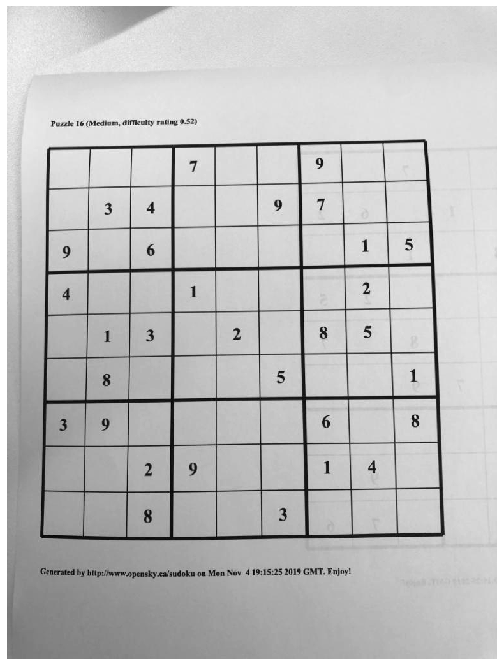

In [170]:
img_origin = cv2.cvtColor(cv2.imread('sodoku.png'), cv2.COLOR_BGR2GRAY)
plot_image(img_origin)

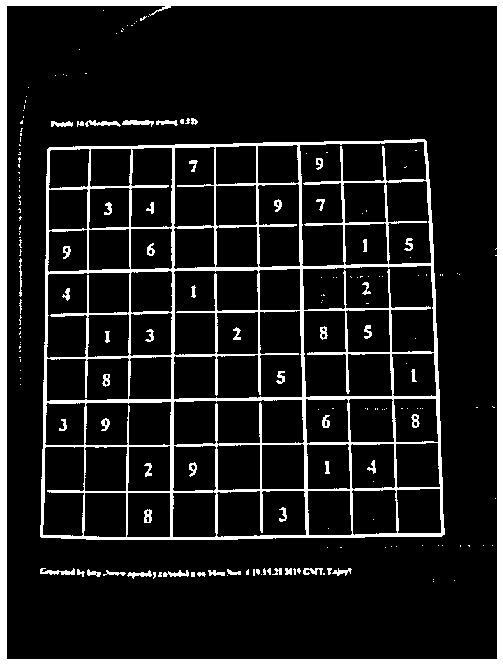

In [171]:
img = cv2.GaussianBlur(img_origin,(11,11),0)
thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
thresh = cv2.bitwise_not(thresh)
plot_image(thresh)

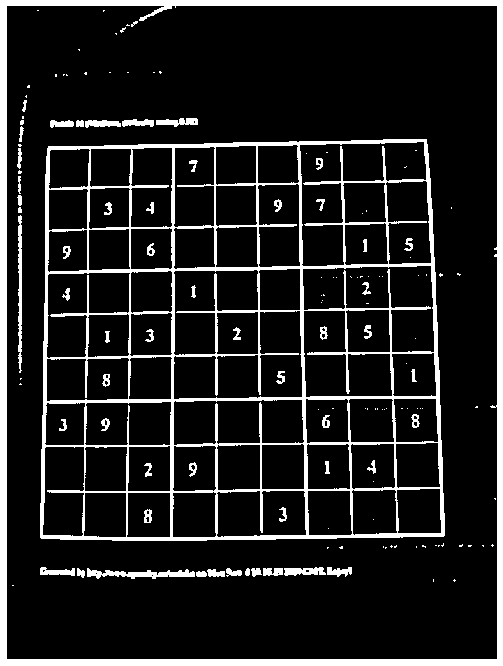

In [172]:
new_img, ext_contours, hier = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
external_only = cv2.drawContours(thresh.copy(), ext_contours, -1, (255, 0, 0), 2)
plot_image(external_only)


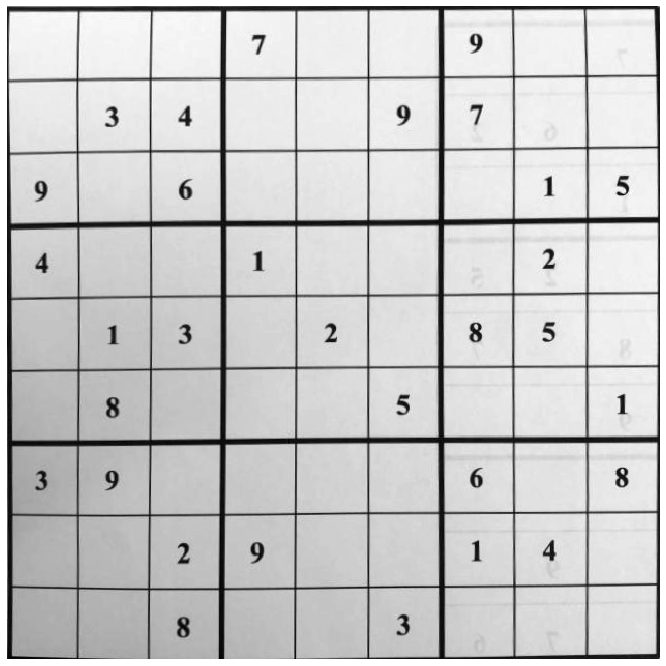

In [173]:
contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
polygon = contours[0]

bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

top_left, top_right, bottom_right, bottom_left = polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]



# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

# Get the longest side in the rectangle
side = max([
    distance_between(bottom_right, top_right),
    distance_between(top_left, bottom_left),
    distance_between(bottom_right, bottom_left),
    distance_between(top_left, top_right)
])

# Describe a square with side of the calculated length, this is the new perspective we want to warp to
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
m = cv2.getPerspectiveTransform(src, dst)

# Performs the transformation on the original image
sodoku = cv2.warpPerspective(img_origin, m, (int(side), int(side)))

plot_image(sodoku)


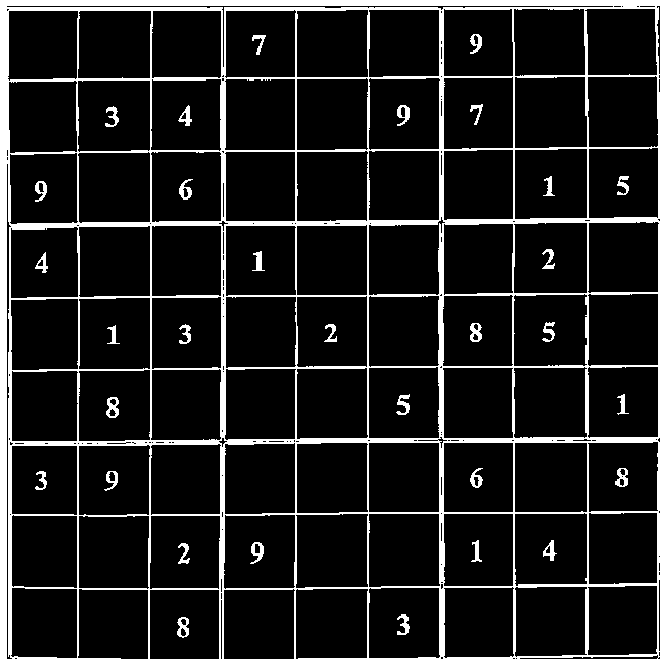

In [230]:
thresh = cv2.adaptiveThreshold(sodoku,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,7)
thresh = cv2.bitwise_not(thresh)

salem = morphology.disk(1)
eroded = morphology.erosion(thresh, salem)
thresh = morphology.reconstruction(eroded, thresh)

plot_image(thresh)

In [238]:
q = 28 # q = quality
cut = 10

#invert the image (this is how MNIST digits is formatted)
array = thresh
#array = cv2.bitwise_not(array)

#this will be the width and length of each sub-image
divisor = array.shape[0]//9

puzzle = []
for i in range(9):
    row = []
    for j in range(9):
        #slice image, reshape it to 28x28 (mnist reader size)
        row.append(cv2.resize(array[i*divisor:(i+1)*divisor,
                                    j*divisor:(j+1)*divisor][cut:-cut, cut:-cut], #removes the borders from each image
                              dsize=(q,q), 
                              interpolation=cv2.INTER_CUBIC))
    puzzle.append(row)



In [242]:
#load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

#standardize the pixel values from 0-255 to 0-1 - neural nets don't like large values!
train_images = train_images.reshape(60000, q, q, 1).astype('float32')/255

#we cannot have a non-binary array to train with, instead we will make a 'dummy' matrix using Pandas
series = pd.Series(train_labels)
train_labels = pd.get_dummies(series)

#build the model
model = tf.keras.models.Sequential()
#add convolutional layers with input that matches our dataset
model.add(tf.keras.layers.Conv2D(254, kernel_size=(3,3), input_shape=(28,28, 1)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3)))
model.add(tf.keras.layers.MaxPool2D((2,2)))
#convert from 2D input to 1D vectors
model.add(tf.keras.layers.Flatten())
#finish our model with densely connected layers
model.add(tf.keras.layers.Dense(140, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(80, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
#output layer with 10 units (one per each class 0-9)
model.add(tf.keras.layers.Dense(units=10, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_images,
          train_labels, 
          epochs=5,
          validation_data = [test_images.reshape(10000,q,q,1).astype('float32')/255,
                             pd.get_dummies(pd.Series(test_labels))])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 161s 3ms/sample - loss: 0.2074 - acc: 0.9401 - val_loss: 0.0580 - val_acc: 0.9804
Epoch 2/5
60000/60000 [==============================] - 157s 3ms/sample - loss: 0.0843 - acc: 0.9765 - val_loss: 0.0486 - val_acc: 0.9857
Epoch 3/5
60000/60000 [==============================] - 160s 3ms/sample - loss: 0.0642 - acc: 0.9824 - val_loss: 0.0552 - val_acc: 0.9844
Epoch 4/5
60000/60000 [==============================] - 158s 3ms/sample - loss: 0.0547 - acc: 0.9848 - val_loss: 0.0336 - val_acc: 0.9898
Epoch 5/5
60000/60000 [==============================] - 160s 3ms/sample - loss: 0.0505 - acc: 0.9864 - val_loss: 0.0442 - val_acc: 0.9877


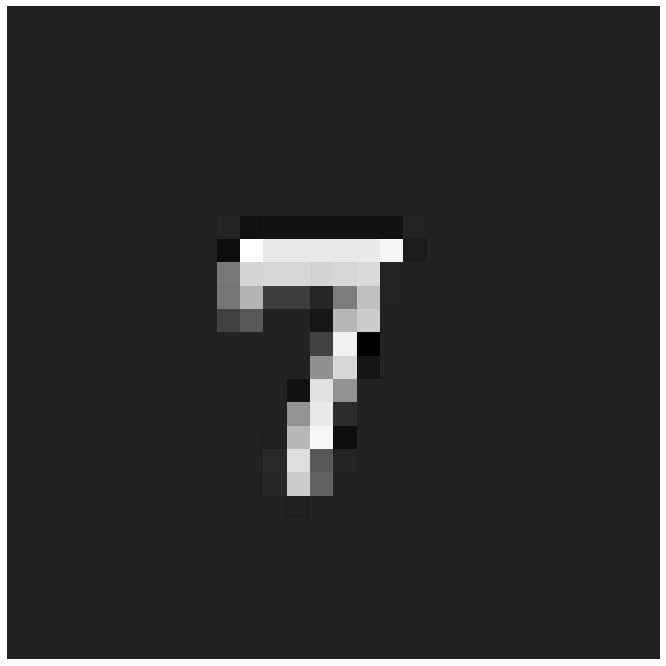

9.556391827450502


1

In [243]:
teste = puzzle[0][3]
plot_image(teste)
print(np.mean(teste))
model.predict_classes(teste.reshape(1,q,q,1).astype('float32')/255)[0]

In [244]:
#create a 9x9 array of 0s (the sudoku solver doesn't use numpy so I won't here)
template = [
    ["-" for _ in range(9)] for _ in range(9)
]

for i, row in enumerate(puzzle):
    for j, image in enumerate(row):
        #if the brightness is above 6, then use the model
        if np.mean(image) > 1:
            #this line of code sets the puzzle's value to the model's prediction
            #the preprocessing happens inside the predict call
            template[i][j] = model.predict_classes(image.reshape(1,q,q,1) \
                                                   .astype('float32')/255)[0]
            

In [245]:
with open('sodoku.txt', 'r') as file:
    data = file.read().replace('\n', '')

hit = 0
super_miss = 0
total = 0
for l,i in enumerate(template):
    for c,j in enumerate(i):
        print(j, end ="" )
        asw = data[c+l*9]
        if asw != "-":
            total +=1
            if (asw == str(j)):
                hit +=1
            if (str(j) == "-"):
                super_miss+=1
                
                
            
    print("\n")

---1--9--

-39--93--

5-6----35

3--3---3-

-13-3-95-

-8---5--3

39----6-5

--29--13-

--8--3---



In [246]:
print("hit porcentage: "+str(hit/total),file=sys.stderr)
print(super_miss,file=sys.stderr)

hit porcentage: 0.5806451612903226
0
